In [1]:
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

## Retail data analysis

This data comes from machine learning repository http://archive.ics.uci.edu/ml/datasets/Online+Retail+II

What we want here to do is the following:
- EDA
- Cluster customers by their purchase behaviour
- Identify customers that churned and predict customer at risk of churning

In [2]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

### Attribute information

- InvoiceNo: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.
- StockCode: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.
- Description: Product (item) name. Nominal.
- Quantity: The quantities of each product (item) per transaction. Numeric.
- InvoiceDate: Invice date and time. Numeric. The day and time when a transaction was generated.
- UnitPrice: Unit price. Numeric. Product price per unit in sterling (Â£).
- CustomerID: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.
- Country: Country name. Nominal. The name of the country where a customer resides.

### Sourcing data and cleaning data

What follows below in a few keys points:
- Sourcing data from excel (loaded from http://archive.ics.uci.edu/ml/datasets/Online+Retail+II#)
- Dropping missing values with respect to Customer ID (as we find that this information is essential to predict customers behaviour)
- Dropping stock codes which do not contain 5-digit numbers as prescribed by the attribute information
- Verifying that "extreme" values of prices (that is, prices that are very large with respect to the mean price) are not outliers. 

In [4]:
data1 = pd.read_excel("online_retail_II.xlsx", sheet_name = "Year 2009-2010")
data2 = pd.read_excel("online_retail_II.xlsx", sheet_name = "Year 2010-2011")

In [5]:
frames = [data1, data2]
data = pd.concat(frames)

In [6]:
#creating a copy of data
df = data.copy()

In [7]:
#we look at how the data looks like
df.head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.0,United Kingdom
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.0,United Kingdom


In [8]:
#let us look at the brief information on this data set
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1067371 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 73.3+ MB


We have the following observations:
- There are 1067371 rows in the data set, and only 824364 rows are available for Customer ID. To predict customers beahviour, we prefer to drop the instances with missing Customer ID. 
- We consider Customer ID, Country, StockCode and Invoice to be categorical variables. We will transform the corresponding columns into string and categorical variables. 

In [9]:
#checking that no missing values are present 
df.isnull().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

In [10]:
#investigating Country variable
df.Country.value_counts().head(15)
#We note that there is an "Unspecified" country listed among others

United Kingdom     981330
EIRE                17866
Germany             17624
France              14330
Netherlands          5140
Spain                3811
Switzerland          3189
Belgium              3123
Portugal             2620
Australia            1913
Channel Islands      1664
Italy                1534
Norway               1455
Sweden               1364
Cyprus               1176
Name: Country, dtype: int64

### Cleaning function

In [12]:
def cleaning(df):
    df.dropna(subset = ['Customer ID'], inplace = True)
    #convering certain columns in categorical variables
    df['Customer ID'] = df['Customer ID'].astype('str').astype('category')
    df['Country'] = df['Country'].astype('category')
    df['StockCode'] = df['StockCode'].astype('str')
    df['Invoice'] = df['Invoice'].astype('str').astype('category')
    
    #The attribute description says that stock code should be a 5-digit integral number
    #Hence, we drop all instances which do not satisfy this condition using regular expression
    col = df.StockCode.map(lambda x: str(x)).map(lambda x: bool(re.match("\d\d\d\d\d", x)))
    
    df = df[col]
    #finally, we drop duplicates in our data frame 
    df.drop_duplicates(inplace = True)
    
    return df

In [13]:
#we clean our data frame
df = cleaning(df)

In [14]:
#no missing values anyore!
df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [15]:
df.shape
#we still have a good amount of data

(794223, 8)

In [16]:
#for further cleaning of the data, we will take a look at the summary statistics
df.describe()

,Quantity,Price
count,794223.000000,794223.000000
mean,12.652839,2.971190
std,192.078928,4.474925
min,-80995.000000,0.000000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,649.500000


We see that there is a large deviation from the maximum price from the mean (much larger than 3 deviations from it). Let us take a look at this data to confirm that these values make sense

In [17]:
df[df.Price>100].sort_values('Price')

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
61549,541426,22823,CHEST NATURAL WOOD 20 DRAWERS,4,2011-01-18 08:44:00,110.0,18233.0,United Kingdom
482787,534657,22823,CHEST NATURAL WOOD 20 DRAWERS,2,2010-11-23 13:36:00,110.0,14252.0,United Kingdom
66293,541789,22823,CHEST NATURAL WOOD 20 DRAWERS,3,2011-01-21 13:07:00,110.0,14088.0,United Kingdom
414573,528970,22823,CHEST NATURAL WOOD 20 DRAWERS,2,2010-10-26 10:24:00,110.0,14298.0,United Kingdom
332640,521911,21760,FRENCH STYLE WALL DRESSER,2,2010-09-09 13:20:00,110.0,15972.0,United Kingdom
...,...,...,...,...,...,...,...,...
283393,516949,22656,VINTAGE BLUE KITCHEN CABINET,1,2010-07-25 15:32:00,295.0,16556.0,United Kingdom
282682,516913,22656,VINTAGE BLUE KITCHEN CABINET,1,2010-07-25 11:07:00,295.0,13875.0,United Kingdom
279619,516610,22655,VINTAGE RED KITCHEN CABINET,1,2010-07-21 14:41:00,295.0,13615.0,United Kingdom
222682,556446,22502,PICNIC BASKET WICKER 60 PIECES,1,2011-06-10 15:33:00,649.5,15098.0,United Kingdom


Larger prices seem to be reasonable: indeed, a drawer can be priced at 110 USD and more expensive items such as vintage cabinet can be prices at 295 USD. A picnic basket seems to be quite expensive (649 USD), however we looked on Amazon and such prices do exist for picnic baskets. 

## Exploratory Data Analysis

In what follows, we make the following observations:
- Largest spenders in terms of Quantity and Price are: the UK, Netherlands, EIRE, Denmark, Germany and France
- Customers usually buy (and cancel) a lot if the price of an item is small, and buy (and cancel) much less frequently if the price of an item is large. 
- September to November are the largest sales months! It might be due to Black Friday, Halloween, Thanksgiving and upcoming Christmas holidays. 
- The most popular products in terms of quantity bought are: WORLD WAR 2 GLIDERS ASSTD DESIGNS, WHITE HANGING HEART T-LIGHT HOLDER, ASSORTED COLOUR BIRD ORNAMENT, JUMBO BAG RED RETROSPOT, BROCADE RING PURSE among others.
- The most profitable products in terms of accumulated profit are REGENCY CAKESTAND 3 TIER, DOTCOM POSTAGE, WHITE HANGING HEART T-LIGHT HOLDER, JUMBO BAG RED RETROSPOT, PARTY BUNTING among others. 

##### Accumulated quantity and profit per country and customer

Above we noted that Quantity column can take positive and negative values. Negative values are attributed to the cancellations. 

In [18]:
#Let us take a look at which countires are the largest spenders
#below we see the largest spenders (in terms of Quantity) 
quantity_per_country = df.groupby('Country')['Quantity'].sum().sort_values(ascending = False)

In [19]:
quantity_per_country.head(15)
#We see that the largest spenders in terms of Quantity are the UK, Netherlands, EIRE, Denmark and Germany, France and Australia.

Country
United Kingdom     8192501
Netherlands         382101
EIRE                309531
Denmark             234702
Germany             219803
France              178695
Australia           103372
Sweden               87637
Switzerland          51579
Spain                44367
Belgium              34198
Japan                30143
Portugal             26896
Norway               23470
Channel Islands      20384
Name: Quantity, dtype: int64

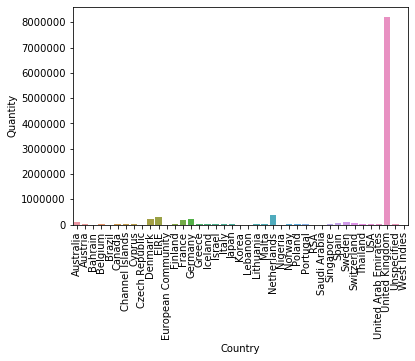

In [20]:
g = sns.barplot(x=quantity_per_country.index, y=quantity_per_country)
plt.xticks(rotation=90)
plt.show()

In [21]:
#Let us take a look at which countires are the largest spenders
#below we see the largest spenders (in terms of Quantity) 
price_per_country = df.groupby('Country')[['Price']].sum().sort_values(by = 'Price', ascending = False).head(15)
price_per_country
#We see that the largest spenders in terms of Quantity are the UK, EIRE, Germany, France, Netherlands, Spain, Belgium.

,Price
Country,
United Kingdom,2.123222e+06
EIRE,5.481818e+04
Germany,4.614110e+04
France,3.512446e+04
Netherlands,1.193902e+04
Spain,1.130111e+04
Belgium,9.031920e+03
Switzerland,8.790340e+03
Channel Islands,6.946880e+03


In [22]:
#We will also find out largest spenders by customer 
quantity_per_cust = df.groupby('Customer ID')['Price'].sum().sort_values(ascending = False)
quantity_per_cust.head(10)

Customer ID
14911.0    39372.54
17841.0    34438.14
14096.0    21426.09
14606.0    18258.11
12748.0    15988.18
14527.0    14138.36
14156.0    13949.96
15311.0    12329.74
13089.0     9276.00
14646.0     9208.11
Name: Price, dtype: float64

##### Trend in customers behaviour: buy a lot of cheap products

Plot below represents the dependency of Price and Quantity. We see that customers buy (or cancel) a lot (large Quantity) if the Price of a product is low. On the other hand, it seems that customers buy (and cancel) very little when the Price goes up.

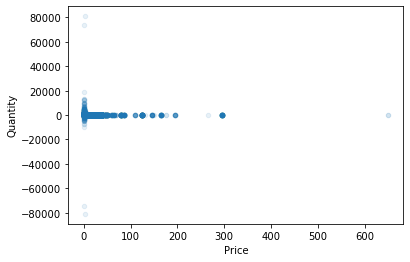

In [23]:
df.plot(kind = 'scatter', x = 'Price', y = 'Quantity', alpha = 0.1)
plt.show()

##### Seasonality

In [24]:
month_sells = df
month_sells['Month'] = month_sells.InvoiceDate.dt.month
month_sells.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Month
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,12
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,12
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,12
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,12
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,12


In [25]:
df_sellmonth = month_sells.groupby('Month')['Quantity'].sum()
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

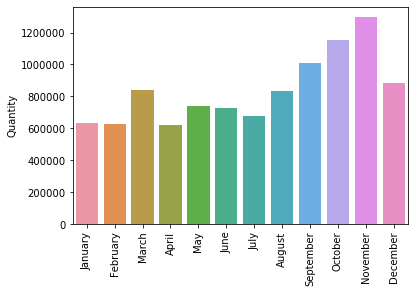

In [26]:
g = sns.barplot(x=months, y=df_sellmonth)
plt.xticks(rotation=90)
plt.show()

We can see that September to November are the largest sales months! It might be due to Halloween, Thanksgiving and upcoming Christmas holidays. 

##### Most popular products

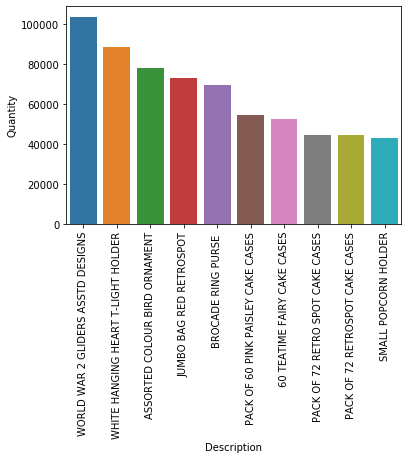

In [27]:
#most popular products in terms of quantity bought
prod_popul = df.groupby('Description')['Quantity'].sum().sort_values(ascending = False)
g = sns.barplot(x=prod_popul.index[0:10], y=prod_popul[0:10])
plt.xticks(rotation=90)
plt.show()

In [28]:
df_amspent = df.copy()
df_amspent['amount_spent'] = df.Quantity * df.Price
#largest income per product
product_income = df_amspent.groupby('Description')['amount_spent'].sum().sort_values(ascending = False)
product_income.head(10)

Description
REGENCY CAKESTAND 3 TIER               261110.95
WHITE HANGING HEART T-LIGHT HOLDER     237678.61
JUMBO BAG RED RETROSPOT                132180.02
ASSORTED COLOUR BIRD ORNAMENT          123631.87
PARTY BUNTING                          102089.38
PAPER CHAIN KIT 50'S CHRISTMAS          75388.48
CHILLI LIGHTS                           68453.50
JUMBO BAG STRAWBERRY                    63615.53
BLACK RECORD COVER FRAME                63009.83
ROTATING SILVER ANGELS T-LIGHT HLDR     55577.77
Name: amount_spent, dtype: float64

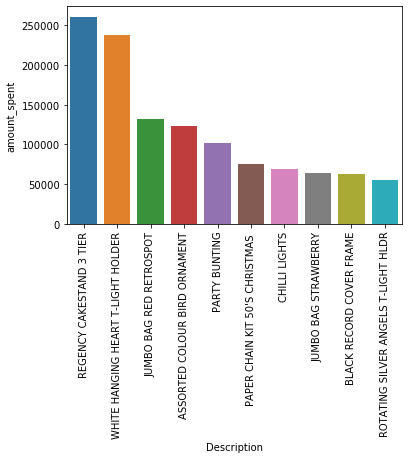

In [29]:
g = sns.barplot(x=product_income.index[0:10], y=product_income[0:10])
plt.xticks(rotation=90)
plt.show()

### Feature Engineering

Here we will create new features to our data frame which will help us classify customers. The following features are created:
- amount_spent per customer which is equal to quantity of a product times its price per customer 
- SinceLastActive is the column reflecting how many days the customer has been active (purchase or cancellation)
- cancelled_item reflects whether the item has been cancelled
- SinceLastPurch is derived from SinceLastActive and reflects whether it has been a purchase (as opposed to cancellation)
- NumInvoices sums up the number of different invoices (i.e. purchases) a customer made
- Frequency is the list of time periods between purchases per customer. In other words, it reflects customers frequency of buying in terms of days
- FreqMean is the mean of frequency per customer. In other words, if FreqMean is equal to n days then we expect the customer to make a purchase every n days.

In [30]:
#cancelled items 
def detect_cancel(x):
    """Detecting whether the item is cancelled or not
    """
    if x<0:
        return abs(x)
    else:
        return 0

In [31]:
def getting_union(x):
    """
    Function returning a set of all products bought by one customer
    """
    return set(x)

In [32]:
def extract_freq(x):
    """
    input: series of dates (of purchase)
    output: number of days between each purchase
    NB: if a customer made a purchase only once then "set_of_days" is set to 0 and will be replaced accordingly in the next function
    """
    dif_x = x.diff().map(lambda x: x.days)
    dif_x.dropna(inplace = True)
    set_of_days = list(dif_x)
    set_of_days = [item for item in set_of_days if item!=0]
    
    if len(set_of_days)==0:
        set_of_days = [0]
    return set_of_days

In [33]:
def func_feature_engineering(df, present_day, initial_day):
    """input: 
    'present_day' and 'initial_day' should be in the formal 'yyyy-mm-dd'. 
    'present_day' is the current day from which we are looking back to (end of Dec 2011)
    
    df: contains features Invoice, StockCode, Description, Quantity,InvoiceDate,Price,Customer ID and Country
    
    output: new data frame with features engineered
    """
    
    #Note, that if we were to characterize customers, we would need a data frame where each instance (row) 
    #would describe one customer. This is not the case for above given data frame df. 
    #Moreover, we would need such a standard data frame to be able to run any machine learning algorithm on it. 
    
    df['cancelled_item'] = df.Quantity.map(lambda x: detect_cancel(x))
    df['amount_spent'] = df.Quantity * df.Price
    
    #introducing new feature: Since last activity of the customer
    present_day_pd = pd.to_datetime(present_day)
    df['SinceLastActive'] = (present_day_pd - df['InvoiceDate']).map(lambda x: x.days)
    
    #we will add an important feature of the recency of the customer (last date of purchase)
    SinceLastPurch = df[df.Quantity>0].groupby('Customer ID')[['SinceLastActive']].min()
    SinceLastPurch.reset_index(level = 0, inplace = True)
    SinceLastPurch.columns = ['Customer ID', 'SinceLastPurch']
    
    #add feature of the number of invoices per customer
    df_invoice = df[df.Quantity>0]
    num_invoice = df_invoice.groupby(['Customer ID'])[['Invoice']].nunique()
    num_invoice.reset_index(inplace = True)
    num_invoice.columns = ['Customer ID', 'NumInvoices']
    
    #adding frequency: i.e. how often does the customer make a purchase?
    df_freq = df.copy()
    df_freq = df_freq.sort_values('InvoiceDate', ascending = True)
    df_freq = df_freq[df_freq.Quantity>0]
    df_freq = df_freq[['Customer ID', 'Invoice', 'InvoiceDate']].drop_duplicates()
    freq_cust = df_freq.groupby('Customer ID')[['InvoiceDate']].agg({extract_freq})
    freq_cust.reset_index(inplace = True)
    freq_cust.dropna(inplace = True)
    freq_cust.columns = ['Customer ID', 'Frequency']
    
    #introducing the new data frame: each instance corresponds to a unique customer
    df_new = df.groupby(['Customer ID'])[['Quantity', 'amount_spent', 'cancelled_item', 'Description', 'Country']].agg({
        'Quantity': sum,
        'amount_spent': sum,
        'cancelled_item': sum,
        'Description': getting_union,
        'Country': list
    })
    df_new.reset_index(inplace = True)
    
    #additional cleaning steps are set in place
    len_coun = df_new.Country.apply(lambda x: len(x))
    nonzero_len = len_coun!=0
    df_new = df_new[nonzero_len]
    df_new.Country = df_new.Country.map(lambda x: x[0])
    
    #merging new data set with features engineered above
    df_new = pd.merge(df_new, SinceLastPurch, on = 'Customer ID', how = 'outer')
    df_new = pd.merge(df_new, num_invoice, on = 'Customer ID', how = 'outer')
    df_new = pd.merge(df_new, freq_cust, on = 'Customer ID', how = 'outer')
    
    #those customers that had Frequency = [0]: we will set the Frequency to the maximum period observed (i.e. 2 years)
    rows_to_change = df_new['Frequency'].map(lambda x: x==[0])
    for i in range(df_new.shape[0]):
        if rows_to_change[i]:
            df_new['Frequency'][i] = [(present_day - initial_day).days]
        
        
    #add one more feature of Frequency mean
    df_new['FreqMean'] = df_new['Frequency'].map(lambda x: np.mean(x))
    
    return df_new

In [34]:
#this is the data frame that we are engineering with respect to the last day: 31Dec 2011
df_ml = func_feature_engineering(df, pd.to_datetime('2011-12-31'), pd.to_datetime('2009-12-01'))

In [35]:
#just in case: if there are missing values, we will drop them
df_ml.dropna(inplace = True)

In [36]:
#let us take a look at how many customers we have
df_ml.shape

(5853, 10)

In [37]:
df_ml.head()

,Customer ID,Quantity,amount_spent,cancelled_item,Description,Country,SinceLastPurch,NumInvoices,Frequency,FreqMean
0,12346.0,24.0,169.36,74215.0,"{DOORMAT FANCY FONT HOME SWEET HOME, DOORMAT I...",United Kingdom,346.0,3,"[118.0, 203.0]",160.5
1,12347.0,2967.0,4921.53,0.0,"{REVOLVER WOODEN RULER , MAGIC DRAWING SLATE S...",Iceland,23.0,8,"[37.0, 49.0, 70.0, 63.0, 53.0, 90.0, 37.0]",57.0
2,12348.0,2704.0,1658.40,0.0,"{72 CAKE CASES DOLLY GIRL DESIGN, 72 SWEETHEAR...",Finland,96.0,5,"[80.0, 39.0, 70.0, 173.0]",90.5
3,12349.0,1616.0,3654.54,5.0,"{SET/5 RED RETROSPOT LID GLASS BOWLS, PINK CAT...",Italy,39.0,3,"[181.0, 389.0]",285.0
4,12350.0,196.0,294.40,0.0,"{BLUE POLKADOT PASSPORT COVER, PINK/PURPLE RET...",Norway,331.0,1,[760],760.0


## Splitting the customers into groups 

In what follows, we select the most important features characterizing customers and perform clustering modeling. We list the conclusions obtained from the below analysis with the four categories of customers:
- "Best customers". This class of customers brings the largest profit on average, they make the largest amount of purchases and the time between their purchases is short. 
- "Good customers". This class of customers brings a good portion of your income (but less than best customers by the order of magnitude) and, while these customers don't shop very often, they tend to always come back after a month or two. 
- "Irregular customers". These customers shop rarely and little, around 3.5 times a year. You expect them to come back to the shop eventually, their frequency of purchases is between 3 to 6 months. The income brought by these customers is not very large. 
- "One time customers". These customers have purchased something only once on average and they bring a negligible portion of your income. 

We believe the cancelled item is not a very useful column given that we have an aggregated amount_spent which reflects cancellations. Moreover, while we do think that baskets of products (Description set) and Country can be useful, for now we will drop them. Moreover, for the clustering purpose, Customer ID will not bring any useful information given that each instance has a different Customer ID. 

In [38]:
df_clustering = df_ml[['Quantity', 'amount_spent', 'SinceLastPurch', 'NumInvoices', 'FreqMean']]

In [39]:
df_clustering

,Quantity,amount_spent,SinceLastPurch,NumInvoices,FreqMean
0,24.0,169.36,346.0,3,160.500000
1,2967.0,4921.53,23.0,8,57.000000
2,2704.0,1658.40,96.0,5,90.500000
3,1616.0,3654.54,39.0,3,285.000000
4,196.0,294.40,331.0,1,760.000000
...,...,...,...,...,...
5871,1677.0,2658.95,24.0,22,35.777778
5872,493.0,411.68,452.0,1,760.000000
5873,144.0,377.00,681.0,1,760.000000
5874,591.0,1138.43,497.0,2,247.000000


#### Using KMeans for clustering

As a clustering method we will use KMeans. Note, that features in KMeans should be normalized (otherwise there will be a bias towards larger values in certain columns). 

In [40]:
scaler = StandardScaler()
scaler.fit(df_clustering)
df_clust_normalized = scaler.transform(df_clustering)

We will start with a simple KMeans clustering with 2 clusters. 

In [41]:
#Let us look what happens if we split the data only in 2 clusters
kmeans = KMeans(n_clusters=2, random_state=1)
kmeans.fit(df_clust_normalized)
cluster_labels = kmeans.labels_

In [42]:
df_clust_lab = df_ml.assign(Cluster = cluster_labels)

In [43]:
df_clust_lab.groupby(['Cluster']).agg({
    'SinceLastPurch': 'mean',
    'Quantity': 'mean',
    'amount_spent': 'mean',
    'NumInvoices': 'mean',
    'FreqMean': 'mean'
}).round(0)

,SinceLastPurch,Quantity,amount_spent,NumInvoices,FreqMean
Cluster,,,,,
0,221.0,1342.0,2214.0,6.0,299.0
1,59.0,111229.0,172243.0,137.0,11.0


We note that the split into two clusters is fairly intuitional. More specifically:
- On average, customers in category 0 have not purchased in a long time ago, they are not very frequent customer either. On the other hand, customers in category 1 have purchased more recently and have are on average frequent customers.
- Customers in category 0 did not purchase a lot in terms of quantity and the total amount spent, while customers in category 1 purchased a lot in terms of quantity and amount spent. 
- The number of invoices in category 0 is low and the number of invoice in category 1 is high. 

We further look at enhancing our clustering method to more clusters. 

To see how many clusters it is worth introducing (note, that in KMeans method you have to set the number of clusters yourself), we check the so-called intertia plot (and look for an elbow) as well as we will look at the silhouette score. 

In [44]:
inert = np.zeros(7)
silh_score = np.zeros(7)
for i in range(2,9):
    kmeans = KMeans(n_clusters = i)
    y_pred = kmeans.fit_predict(df_clust_normalized)
    inert[i-2] = kmeans.inertia_
    silh_score[i-2] = silhouette_score(df_clust_normalized, kmeans.labels_)

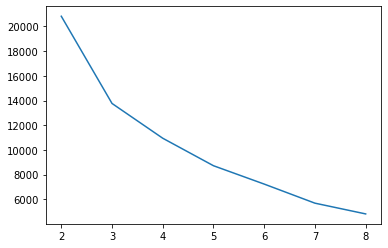

In [45]:
plt.plot(np.arange(2,9), inert)

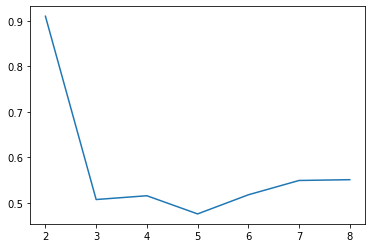

In [46]:
plt.plot(np.arange(2,9), silh_score)

#### Conclusions on the number of clusters:
Based on the trade-off between the inertia plot (elbow detecting) and silhouette (larger silh is better), we decide to choose k = 4.

In [47]:
#Let us look what happens if we split the data in 5 clusters
kmeans = KMeans(n_clusters=4, random_state=1)
kmeans.fit(df_clust_normalized)
cluster_labels = kmeans.labels_
df_clust_lab = df_clustering.assign(Cluster = cluster_labels)
df_clust_lab.groupby(['Cluster']).agg({
    'SinceLastPurch': 'mean',
    'Quantity': 'mean',
    'amount_spent': 'mean',
    'NumInvoices': 'mean',
    'FreqMean': 'mean'
}).round(0)

,SinceLastPurch,Quantity,amount_spent,NumInvoices,FreqMean
Cluster,,,,,
0,368.0,231.0,381.0,1.0,751.0
1,160.0,1601.0,2700.0,7.0,107.0
2,74.0,45745.0,62465.0,84.0,32.0
3,24.0,206977.0,369660.0,190.0,8.0


### Conclusions on clustering

- "Best customers". This class of customers brings the largest profit on average, they make the largest amount of purchases and the time between their purchases is short. 
- "Good customers". This class of customers brings a good portion of your income (but less than best customers by the order of magnitude) and, while don't shop very often, they tend to always come back after a month or two. 
- "Irregular customers". These customers shop rarely and little, around 3.5 times a year. You expect them to come back to the shop eventually, their frequency of purchases is between 3 to 6 months. The income brought from these customers is not very large. 
- "One time customers". These customers have purchased something only once on average and their bring a negligible portion of your income. 

## Detecting churning customers

Below the following steps are taken:
- Definition of Churned customer is established and added to the data frame
- Data frame was further processed in categorical variables (OneHotEncoding), numerical variables were scaled. Data was split into train data and test data. 
- Logistic regression was performed to predict churned customers
- Random Forest model also was used to predict churned customers. The performance of Random Forest was detected to be superior to Logistic regression through AUC metric. 

### Conclusions of what follows below:

#### The following customers are churned in the second half of 2011: 

['12685.0', '12748.0', '12856.0', '12947.0', '12971.0', '12980.0',
       '13027.0', '13037.0', '13082.0', '13089.0', '13162.0', '13291.0',
       '13491.0', '13593.0', '13631.0', '13695.0', '13752.0', '13755.0',
       '13802.0', '13869.0', '14045.0', '14096.0', '14156.0', '14344.0',
       '14364.0', '14414.0', '14434.0', '14461.0', '14472.0', '14527.0',
       '14547.0', '14606.0', '14680.0', '14692.0', '14911.0', '14918.0',
       '15005.0', '15039.0', '15245.0', '15260.0', '15311.0', '15410.0',
       '15523.0', '15581.0', '15623.0', '15768.0', '15827.0', '15885.0',
       '15939.0', '16027.0', '16029.0', '16174.0', '16180.0', '16422.0',
       '16549.0', '16550.0', '16729.0', '16745.0', '16919.0', '16928.0',
       '17061.0', '17085.0', '17126.0', '17377.0', '17457.0', '17460.0',
       '17692.0', '17719.0', '17723.0', '17837.0', '17841.0', '17848.0',
       '17894.0', '17931.0', '17961.0', '17997.0', '18008.0', '18037.0',
       '18073.0', '18116.0', '18178.0', '18226.0']
       
#### The following customers are considered to be at risk of churning:
{'13408.0', '13694.0', '13798.0', '14646.0', '17509.0'}


Customers that are at risk of churning are customers that make purchases very often and bring a lot of income in terms of their amount spent. Hence, it would be recommended to offer them a premium, or a loyalty program or a promotion on products to keep them. 

### Defining churned customers

First, we have to define "churned" customers. These are customers that we don't expect to come back. Note, that contractual churned customers are much easier identified (as they stop their subscription, for instance). In case of a retailer, one will have to come up with a definition of a churned customer. 

One could define a churned customer based on average customers statistics (e.g. a customer did not come back for a month or two). We decided to exploit more personalized approach, where we define "abnormally long time without a purchase" that is specific to a customer  based on his previous purchase history and behaviour. 

The above can be expressed in terms of "SinceLastPurch" (since last purchase) and the general trend in customers purchase frequency. We exploited two possibilities:
- Churned customer is a customer for which SinceLastPurch is larger than the 80% quantile of its normal purchase frequency times two. We fine tuned the coefficient $2$ assuming the seasonality in purchases. 
- Churned customer is a customer for which SinceLastPurch is larger than the Frequency Mean + 3 Standard Deviations of Frequencies. This is a standard approach to find outliers if your underlying data follows normal distribution. 

By having analyzed two these approaches, we found that they are relatively close in terms number of customers defined churned. Both approaches give similar result, so we will continue with the first one. 

Moreover, since the question was about the second half of 2011, we will have to filter our "churned" customers by those whose "SinceLastPurch" is less than 180 days. 

Note that for customers that visited the store too few times, we cannot meaningfully say whether they churned or not. These occasional customers will be excluded from further analysis. 

In [48]:
df_churned = df_ml.copy()
#excluding occasional customers
df_churned = df_churned[df_churned.Frequency.map(lambda x: len(x)) >= 5]
df_churned.reset_index(drop = True, inplace = True)

In [49]:
df_churned.shape

(1666, 10)

In [50]:
df_churned['Quant80'] = df_churned['Frequency'].map(lambda x: np.quantile(x, 0.8))
df_churned['Churned'] = df_churned['SinceLastPurch'] > df_churned['Quant80'].map(lambda x: 2*x)

#investigating the Churned customers
filtering_churned = df_churned['Churned']==True
filter_last_half_2011 = df_churned['SinceLastPurch'] < 180

final_filter = np.zeros(len(filtering_churned),dtype=bool)
for i in range(len(filtering_churned)):
    if (filtering_churned[i] and filter_last_half_2011[i]):
        final_filter[i] = True
    else:
        final_filter[i] = False
        
churned_last_half_2011 = df_churned[final_filter]
churned_last_half_2011['Churned'] = churned_last_half_2011['Churned'].astype('int')

In [51]:
#churned customers:
np.array(churned_last_half_2011['Customer ID'])

array(['12685.0', '12748.0', '12856.0', '12947.0', '12971.0', '12980.0',
       '13027.0', '13037.0', '13082.0', '13089.0', '13162.0', '13291.0',
       '13491.0', '13593.0', '13631.0', '13695.0', '13752.0', '13755.0',
       '13802.0', '13869.0', '14045.0', '14096.0', '14156.0', '14344.0',
       '14364.0', '14414.0', '14434.0', '14461.0', '14472.0', '14527.0',
       '14547.0', '14606.0', '14680.0', '14692.0', '14911.0', '14918.0',
       '15005.0', '15039.0', '15245.0', '15260.0', '15311.0', '15410.0',
       '15523.0', '15581.0', '15623.0', '15768.0', '15827.0', '15885.0',
       '15939.0', '16027.0', '16029.0', '16174.0', '16180.0', '16422.0',
       '16549.0', '16550.0', '16729.0', '16745.0', '16919.0', '16928.0',
       '17061.0', '17085.0', '17126.0', '17377.0', '17457.0', '17460.0',
       '17692.0', '17719.0', '17723.0', '17837.0', '17841.0', '17848.0',
       '17894.0', '17931.0', '17961.0', '17997.0', '18008.0', '18037.0',
       '18073.0', '18116.0', '18178.0', '18226.0'],

We come back now to the df_ml data frame, we will attached "Churned" target and will train the model to predict it. 

In [52]:
customers_churned = churned_last_half_2011['Customer ID']
df_ml['Churned'] = df_ml['Customer ID'].map(lambda x: x in list(customers_churned)).astype('int')
#enreaching the data with more features and deleting unnecessary ones
df_ml['FreqQ75'] = df_ml['Frequency'].map(lambda x: np.quantile(x, 0.75))
df_ml['FreqQ25'] = df_ml['Frequency'].map(lambda x: np.quantile(x, 0.25))

#the set of different countries is too large. We will pick countries that bring the most income and all others set to "others"
def detect_country(x):
    set_of_countries = ['United Kingdom', 'EIRE', 'Germany','France','Netherlands', 'Spain','Belgium', 'Switzerland']
    if x in set_of_countries:
        return x
    else:
        return "Other"
    

df_ml['CountryCat'] = df_ml['Country'].map(lambda x: detect_country(x))

In [53]:
df_working = df_ml.drop(columns = ['Frequency', 'Description', 'Country'])

In [54]:
#Separating categorical and numberical columns
custid = ['Customer ID']
target = ['Churned']
categorical = df_working.nunique()[df_working.nunique()<10].keys().tolist()
categorical.remove(target[0])
numerical = [col for col in df_working.columns if col not in custid  + target + categorical]

#One-hot-encoding categorical variables
df_working = pd.get_dummies(data=df_working, columns=categorical, drop_first=True)

#Scaling numberical features
#Initialize StandardScaler instance
scaler = StandardScaler()
# Fit the scaler to numerical columns
scaled_numerical = scaler.fit_transform(df_working[numerical])
# Build a DataFrame
scaled_numerical = pd.DataFrame(scaled_numerical, columns=numerical)
#Drop non-scaled numerical columns
df_working = df_working.drop(columns=numerical, axis=1)

In [55]:
df_working.reset_index(drop = True, inplace = True)

# Merge the non-numerical with the scaled numerical data
frames = [df_working, scaled_numerical]
df_prepared = pd.concat(frames, axis=1)

In [56]:
features = [item for item in df_prepared.columns if item != 'Customer ID' and item!='Churned']
Y = df_prepared[['Churned']]
X = df_prepared[features]

# Split data to training and testing
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state = 42)

### Using logistics regression

In [57]:
log_reg = LogisticRegression(solver="liblinear", random_state=42)
log_reg.fit(X_train, y_train)
y_proba = log_reg.predict_proba(X_test)[:,1]
y_pred = log_reg.predict(X_test)

Note, that given that the data is unbalanced (there are many more not churned customers than churned. 
Hence, the standard accuracy score will not be useful. We will make use of the ROC curve instead. 

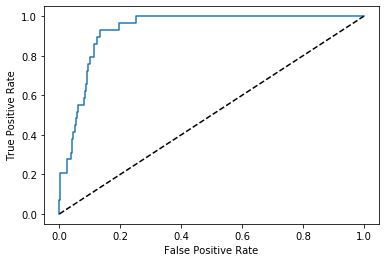

In [58]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0, 1], [0, 1], "k--")
plt.show()

In [59]:
#Area under the curve
auc = roc_auc_score(y_test, y_proba)
print("The area under ROC curves for Logistic Regression on Test Data is: ", auc)

The area under ROC curves for Logistic Regression on Test Data is:  0.9310344827586208


The above predictor is not too bad. Note that for a random classifier, the area under the ROC curve is 0.5

### Using Random Forests

In [72]:
#Fine tuning of the number of leaf nodes: we choose the one that has AUC largest (for test data)
for max_lef_n in range(5,20):
    rnd_clf = RandomForestClassifier(n_estimators = 500, max_leaf_nodes = max_lef_n, n_jobs = -1)
    rnd_clf.fit(X_train, y_train)
    y_pred_rf = rnd_clf.predict(X_test)
    #take argument #1 in probability prediction to see probability of churned
    y_pred_rf_proba = rnd_clf.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, y_pred_rf_proba)
    print("For max leaf nodes ", max_lef_n, "the AUC is ", auc)

For max leaf nodes  5 the AUC is  0.9622732187913012
For max leaf nodes  6 the AUC is  0.9721734951339662
For max leaf nodes  7 the AUC is  0.9772678120869878
For max leaf nodes  8 the AUC is  0.9797188513757059
For max leaf nodes  9 the AUC is  0.9784693019343986
For max leaf nodes  10 the AUC is  0.9830349633545595
For max leaf nodes  11 the AUC is  0.9826985461972846
For max leaf nodes  12 the AUC is  0.9820016820857864
For max leaf nodes  13 the AUC is  0.9822419800552685
For max leaf nodes  14 the AUC is  0.9829148143698186
For max leaf nodes  15 the AUC is  0.9845488405622972
For max leaf nodes  16 the AUC is  0.9792142256397933
For max leaf nodes  17 the AUC is  0.9849573471104169
For max leaf nodes  18 the AUC is  0.9830830229484561
For max leaf nodes  19 the AUC is  0.9866634626937402


In [73]:
rnd_clf = RandomForestClassifier(n_estimators = 500, max_leaf_nodes = 19, n_jobs = -1)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)
#take argument #1 in probability prediction to see probability of churned
y_pred_rf_proba = rnd_clf.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_pred_rf_proba)

In [74]:
print("The area under ROC curves for Random Forest on Test Data is: ", auc)

The area under ROC curves for Random Forest on Test Data is:  0.9871440586327045


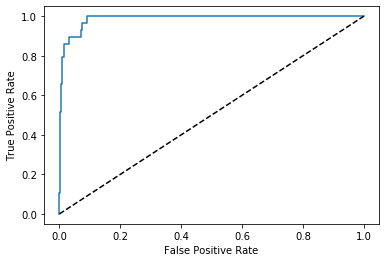

In [75]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_rf_proba)
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0, 1], [0, 1], "k--")
plt.show()

A better performance compared to the logistic regression!

In [76]:
y_full_data = rnd_clf.predict(X)
#take argument #1 in probability prediction to see probability of churned
y_pred_proba_full = rnd_clf.predict_proba(X)[:,1]

In [77]:
df_ml['proba_churn'] = y_pred_proba_full
df_ml['predict_churn'] = y_full_data

In [78]:
#We will define customer at risk as those that have probability of churn above 0.3
#we also substract those customers that we already classified as churned
cust_at_risk_proba = set(df_ml[df_ml['proba_churn']>=0.3]['Customer ID'])
cust_at_risk_pred = set(df_ml[df_ml['predict_churn']==1]['Customer ID'])
cust_at_risk = cust_at_risk_proba.union(cust_at_risk_pred)
cust_at_risk = cust_at_risk.difference(set(churned_last_half_2011['Customer ID']))

In [79]:
cust_at_risk

{'13408.0', '13694.0', '13798.0', '14646.0', '17509.0'}

In [80]:
#let us finally look at the data corresponding to these customers to see if we can explain why they are at risk of churning
customers_at_risk = df_ml[df_ml['Customer ID'].map(lambda x: x in cust_at_risk)][['Customer ID', 
                                                                                 'Quantity', 'amount_spent',
                                                                                'SinceLastPurch', 'Country', 
                                                                                'NumInvoices', 'FreqMean']]

In [81]:
customers_at_risk

,Customer ID,Quantity,amount_spent,SinceLastPurch,Country,NumInvoices,FreqMean
1044,13408.0,28525.0,49751.36,22.0,United Kingdom,106,9.293333
1325,13694.0,184542.0,190391.50,24.0,United Kingdom,143,9.283784
1428,13798.0,47253.0,73177.50,22.0,United Kingdom,110,7.114583
2269,14646.0,365596.0,523202.74,22.0,Netherlands,146,8.807692
5102,17509.0,3508.0,6069.24,78.0,United Kingdom,8,2.500000


#### Conclusions
Customers that are at risk of churning are customers that make purchase very often and bring a lot of income in terms of their amount spent. Hence, it would be recommended to offer them a premium, or a loyalty program or a promotion on products to keep them. 

## Final Remarks

There are many more things that one could do here. To list a few:
- Another linear classification method that can be used is SVM. The disadvantage of SVM is that it is not scalable and also that it does not naturally provide us with a probably of churning which we used to identify customers at risk. 
- One could use Ensemble Learning by aggregating classifiers. Ensemble learning is known to outperform even the best stand-alone models. 
- Gradient Boosting could have been used for this type of problem as well. 
- While we dropped the information on the exact baskets of customers, one can use this information in a meaninful way. One of the ways would be to create a bag of words corresponding to all the products, select the most popular ones and set categorical variables on whether the customer bought this product or not. 